# Beta constrained long-short portfolio structuring
Objective: The goal of this analysis was to optimize a portfolio's performance using a combination of quantitative strategies, specifically focusing on achieving a high Sharpe ratio, while maintaining a low beta relative to the market. 

Methodology:
Monte Carlo Simulation: Employed to generate a wide range of possible portfolio outcomes based on random sampling, which helps in maximizing the Sharpe ratio and minimizing the portfolio beta.

Risk Management Techniques: The portfolio adheres to a standard 120-20 investment strategy, allowing for a 120% long position and a 20% short position. Additionally, applied a trailing stop loss to reduce the portfolio’s exposure to sudden market downturns, ensuring that losses are capped at a predefined threshold.

Performance Metrics: Key metrics such as Sharpe ratio, beta, and maximum drawdown were calculated to evaluate the performance and risk profile of the optimized portfolio.

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
short_tickers = ["ETSY", "DXCM", "ILMN", "PAYC", "VFC", "ABNB", "APA", "UPS", "EPAM", "CHTR", "MOS", "EXPE", "MPC", "PANW", "VLO", "COR", "BXP", "MRO", "HAL", "MRNA"]
long_tickers = [
    "CEG", "LH", "BA", "CARR", "DOW", "PH", "EMR", "JBL", "SWK", "URI", "BSX", "DLTR", "ORCL", "HUBB", "LYB", "XYL",
    "HON", "DD", "ROP", "UNH", "IBM", "GRMN", "CMI", "BKR", "GLW", "SYK", "FTV", "ETN", "CHD", "OTIS", "PCAR", "DGX",
    "AME", "DRI", "APH", "AOS", "HUM", "CLX", "ORLY", "CTAS", "ECL", "TER", "TMUS", "MAS", "TDG", "JNPR", "NSC", "FAST",
    "PAYX", "ROK", "ITW", "CSCO", "CPRT", "TMO", "OKE", "EXC", "EMN", "PWR", "NEM", "DOV", "VTR", "TXT", "TXN", "PG",
    "AVY", "DTE", "MGM", "BR", "GD", "ADP", "PPL", "NI", "MLM", "IDXX", "HCA", "SHW", "HWM", "ZTS", "RCL", "GWW", "CDW",
    "CAH", "HPE", "HD", "HSY", "RTX", "UNP", "MCK", "AES", "FICO", "INTC", "JCI", "ATO", "HAS", "LOW", "ALLE", "WELL",
    "ISRG", "VRSN", "TRGP", "LMT"
]
tickers = long_tickers + short_tickers

In [3]:
tickers = long_tickers + short_tickers
portfolio_optimization_start_date = datetime(2022, 1, 1)
portfolio_optimization_end_date = datetime(2024, 11, 13)
data = yf.download(tickers, start=portfolio_optimization_start_date, end=portfolio_optimization_end_date)
daily_returns = data['Adj Close'].pct_change().dropna()

[*********************100%***********************]  121 of 121 completed


In [ ]:
# set seed
np.random.seed(88)

results = []

n_simulations = 25000

risk_free_rate = 0.04
annual_returns = daily_returns.mean() * 252

market_data = yf.download('SPY', start=portfolio_optimization_start_date, end=portfolio_optimization_end_date)
market_returns = market_data['Adj Close'].pct_change().dropna()
market_returns.name = 'Market'

combined_returns = pd.concat([daily_returns, market_returns], axis=1)
cov_matrix_with_market = combined_returns.cov() * 252
cov_matrix = daily_returns.cov() * 252

market_cov = cov_matrix_with_market.iloc[:-1, -1]
market_variance = market_returns.var() * 252


for i in range(n_simulations):
    weights = np.random.uniform(-1, 1, len(tickers))
    # Leverage up to 120% for longs
    weights[:len(long_tickers)] = weights[:len(long_tickers)] * 1.2
    # Limit short positions to -20%
    weights[len(long_tickers):] = weights[len(long_tickers):] * -0.2
    weights /= np.sum(np.abs(weights))
    expected_return = np.dot(weights, annual_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (expected_return - risk_free_rate) / volatility
    beta = np.dot(weights, market_cov) / market_variance
    results.append([sharpe_ratio, beta, i, weights])

optimal_idx = np.argmax([result[0] - result[1] for result in results])
optimal_result = results[optimal_idx]

print(f"Sharpe Ratio: {optimal_result[0]}")
print(f"Beta: {optimal_result[1].item()}")
weights = optimal_result[3]


[*********************100%***********************]  1 of 1 completed
Sharpe Ratio: 1.6021477367842956
Beta: 0.04399769355162708


In [6]:
def simulate_portfolio_with_stop_loss(daily_returns, weights, stop_loss_threshold=0.03):
    portfolio_value = 1
    portfolio_values = [portfolio_value]
    trailing_peak = portfolio_value

    trailing_stop = portfolio_value * (1 - stop_loss_threshold)

    for i in daily_returns.index:
        current_return = (daily_returns.loc[i] * weights).sum()
        portfolio_value *= (1 + current_return)

        if portfolio_value > trailing_peak:
            trailing_peak = portfolio_value
            trailing_stop = trailing_peak * (1 - stop_loss_threshold)

        if portfolio_value < trailing_stop:
            portfolio_value = trailing_stop
            trailing_peak = portfolio_value
            trailing_stop = portfolio_value * (1 - stop_loss_threshold)

        portfolio_values.append(portfolio_value)

    return pd.Series(portfolio_values, index=[daily_returns.index[0]] + list(daily_returns.index))

adjusted_portfolio_values = simulate_portfolio_with_stop_loss(daily_returns, weights)

In [7]:
def calculate_drawdowns(portfolio_values):
    rolling_max = portfolio_values.cummax()
    drawdowns = (portfolio_values - rolling_max) / rolling_max
    return drawdowns

drawdowns = calculate_drawdowns(adjusted_portfolio_values)
max_drawdown = drawdowns.min()
print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: -0.023810561440531126


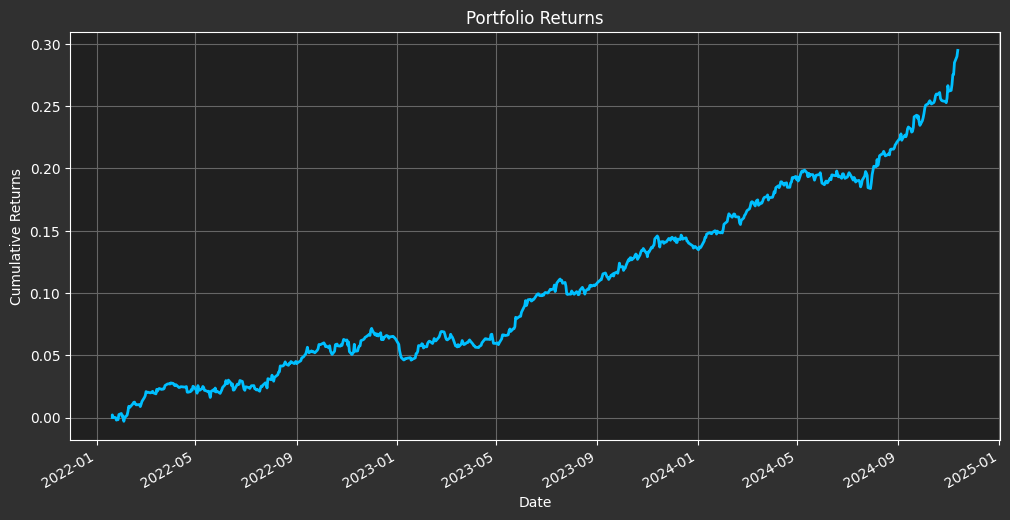

In [8]:
plt.style.use('dark_background')

plt.figure(figsize=(12, 6))
adjusted_cumulative_returns = adjusted_portfolio_values / adjusted_portfolio_values.iloc[0] - 1
ax = adjusted_cumulative_returns.plot(color='deepskyblue', linewidth=2)
ax.set_facecolor('#202020')
ax.figure.set_facecolor('#303030')
plt.title('Portfolio Returns', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Cumulative Returns', color='white')
plt.grid(True, color='#666666')
plt.show()

Key Takeaways:
- The implementation of a 120-20 risk-management strategy along the stop loss demonstrated strong potential for optimizing returns while controlling risk. 
- The low beta emphasizes the portfolio's insulation from market swings, contributing to stability in various market conditions.
- The results validate the effectiveness of the Monte Carlo simulation in navigating complex investment strategies, achieving a balance between high returns and manageable risk levels.
